# EPLs - Matching Ground Truth to Enforcement Data

*Author: Maggie Hilderbran*

Summary: matching expedited payment letter (EPL) ground truth (PDF files of original EPLs) to enforcement data ('enf_actions_export.txt') - all from Erin Mustain @ CA SWRCB.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from pathlib import Path
from IPython.display import clear_output
import sys
import yaml

# turn off warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import & use utility functions sitting in 'main.py'
sys.path.append('../../../ca_mmp')
from policy_eval import main
from policy_eval import scrape_facility_reports

In [3]:
gdrive_dir = '/Users/mhild/Library/CloudStorage/GoogleDrive-mhild@law.stanford.edu/My Drive/EPA/CA Mandatory Minimum Penalty'

In [4]:
print('Reading in configuration and data files.')
clear_output(wait=True)

# read in configuration file
print('Reading in configuration file.')
with open(Path().resolve().parent / 'config.yml', 'r') as file:
    configs = yaml.safe_load(file)
data_path = Path(configs['data_path'])
clear_output(wait=True)

# read in violation data
print('Reading violations flat file.')
violations_flat = pd.read_excel(data_path / 'violations_export_2021-10-26.xlsx', dtype={'FACILITY_ID': str})
clear_output(wait=True)

print('Reading detailed violations file.')
violations_detailed = pd.read_csv(data_path / 'Detailed_Violation_Report.csv')
violations_detailed = violations_detailed.rename(columns={' Date Occured': 'Date Occurred'}, inplace=True)  # fix column name
clear_output(wait=True)

# keep only violations for NPDES permittees & with status != 'Dismissed'
violations_clean = main.clean_violations(violations_flat, mmp_only=False, effluent_only=False)

Reading detailed violations file.


In [5]:
# read enforcement data
print('Reading enforcements file.')
enforcements = pd.read_csv(data_path / 'enf_actions_export.csv',
                           dtype={'FACILITY ID': object},
                           parse_dates=['DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION', 'EFFECTIVE DATE.1', 'ACL ISSUANCE DATE', 'EPL ISSUANCE DATE'],
                           date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
enforcements.rename(columns={'FACILITY ID': 'FACILITY_ID'}, inplace=True)
clear_output(wait=True)

# keep only enforcement actions for NPDES permittees
enforcements = main.clean_enforcements(enforcements, mmp_only=False)
clear_output(wait=True)

# define region groups
enforcements['REGION'] = enforcements['REGION'].astype(str)
enforcements['region_group'] = ['Region 2, 3, 4, 5' if r in ['2', '3', '4', '5S', '5R', '5F'] else 'Region 1, 7' if r in ['1', '7'] else 'Region 8' if r in ['8'] else 'Region 9' if r in ['9'] else 'Other' for r in enforcements['REGION']]

Reading enforcements file.


## Taking a look at the enforcement actions file:

In this section, I take a look at the enforcement actions file we received from Erin ('enf_actions_export.txt').

Goal: to assess the quality of the date fields for the purposes of identifying when EPLs were issued.

In [6]:
# considering the easiest option first - EPL ISSUANCE DATE

# identifying EPL enforcement actions
enforcements_EPL = enforcements[
    # either a) have a valid ACL issuance date and some mention of an EPL in the enforcement action
    (((enforcements['ENFORCEMENT ACTION TYPE'] == 'Expedited Payment Letter') |
      (enforcements['TITLE'].str.contains('Expedited Payment Letter')) |
      (enforcements['TITLE'].str.contains('EPL'))) &
     (~pd.isna(enforcements['ACL ISSUANCE DATE']))) |
    # or b) have a valid EPL issuance date
    (~(pd.isna(enforcements['EPL ISSUANCE DATE'])))]

# number of EPLs issued by EPL issuance date
print("EPLs issued by date ('EPL ISSUANCE DATE'):\n", enforcements_EPL['EPL ISSUANCE DATE'].value_counts())

# total number of EPLs issued
print('\ntotal number of EPLs: ', len(enforcements_EPL))

EPLs issued by date ('EPL ISSUANCE DATE'):
 2008-12-09    34
2010-08-03    22
2008-12-19    20
2008-07-24    20
2021-03-10    16
              ..
2016-11-18     1
2017-11-07     1
2016-05-13     1
2013-02-15     1
2017-05-16     1
Name: EPL ISSUANCE DATE, Length: 626, dtype: int64

total number of EPLs:  1299


"fig, ax = plt.subplots(1, 1, figsize=(30,10))\nax.hist(enforcements[enforcements.region_group == 'Region 2, 3, 4, 5']['EPL ISSUANCE DATE'], bins = len(pd.unique(enforcements['EPL ISSUANCE DATE'])))\nax.hist(enforcements[enforcements.region_group != 'Region 2, 3, 4, 5']['EPL ISSUANCE DATE'], bins = len(pd.unique(enforcements['EPL ISSUANCE DATE'])))\nax.legend(['regions 2, 3, 4, and 5', 'other regions'])\nax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))\nax.xaxis.set_major_locator(mdates.YearLocator())\nfig.autofmt_xdate()\nax.set_title('temporal distribution of EPL issuance dates (EPL ISSUANCE DATE) by region')\nax.set_xlabel('date')\nax.set_ylabel('# of EPLs issued')"

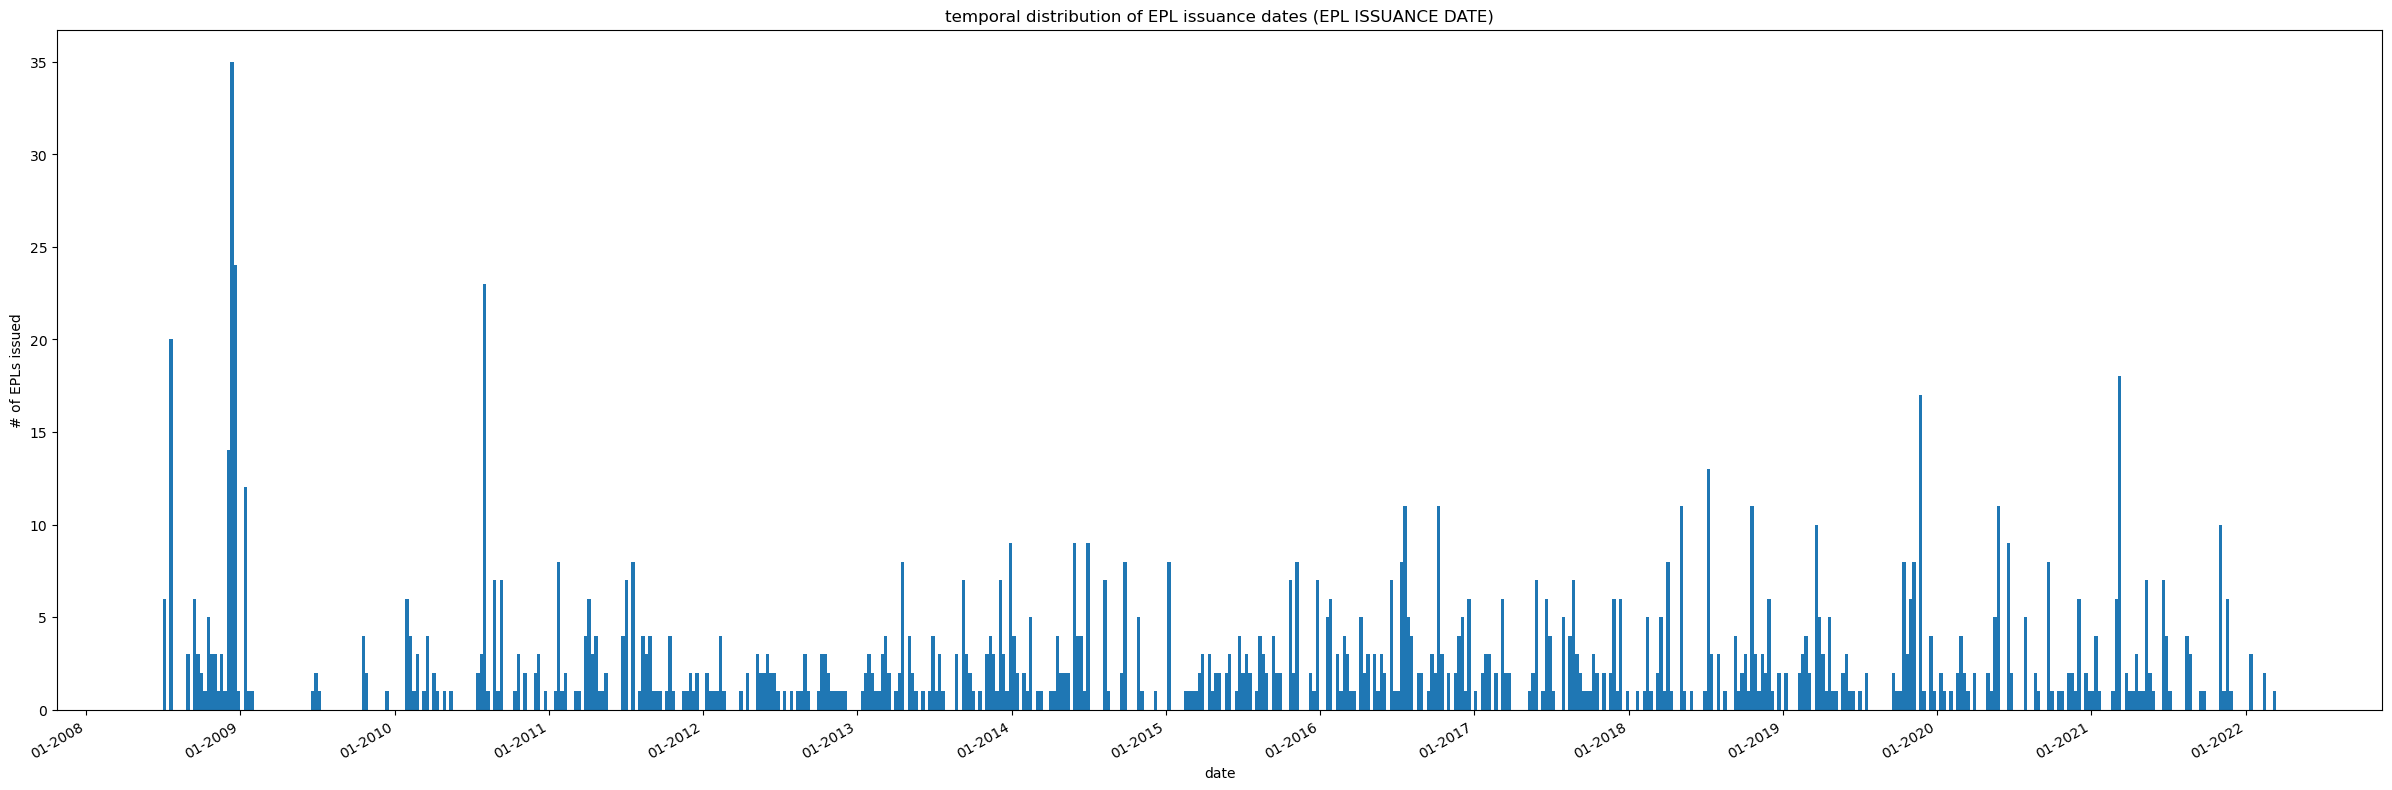

In [7]:
# looking at temporal distribution of EPL ISSUANCE DATE values

# count of EPLs issued over time
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.hist(enforcements['EPL ISSUANCE DATE'], bins = len(pd.unique(enforcements['EPL ISSUANCE DATE'])))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()
ax.set_title('temporal distribution of EPL issuance dates (EPL ISSUANCE DATE)')
ax.set_xlabel('date')
ax.set_ylabel('# of EPLs issued')

# count of EPLs issued over time (by region)
'''fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.hist(enforcements[enforcements.region_group == 'Region 2, 3, 4, 5']['EPL ISSUANCE DATE'], bins = len(pd.unique(enforcements['EPL ISSUANCE DATE'])))
ax.hist(enforcements[enforcements.region_group != 'Region 2, 3, 4, 5']['EPL ISSUANCE DATE'], bins = len(pd.unique(enforcements['EPL ISSUANCE DATE'])))
ax.legend(['regions 2, 3, 4, and 5', 'other regions'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()
ax.set_title('temporal distribution of EPL issuance dates (EPL ISSUANCE DATE) by region')
ax.set_xlabel('date')
ax.set_ylabel('# of EPLs issued')'''

In [8]:
# range of effective dates (using EFFECTIVE DATE.1 because that's the effective date associated w/the enforcement action)
print("range of effective dates ('EFFECTIVE DATE.1'):\n", enforcements.dropna(subset=['EFFECTIVE DATE.1'])['EFFECTIVE DATE.1'].sort_values())

range of effective dates ('EFFECTIVE DATE.1'):
 36466   1973-06-26
1165    1974-04-26
2187    1974-04-26
6543    1976-08-23
37406   1977-04-07
           ...    
13904   2022-03-15
10917   2022-03-15
35315   2022-04-01
36464   2064-10-15
36465   2066-06-16
Name: EFFECTIVE DATE.1, Length: 10691, dtype: datetime64[ns]


Text(0, 0.5, '# of enforcement actions made effective')

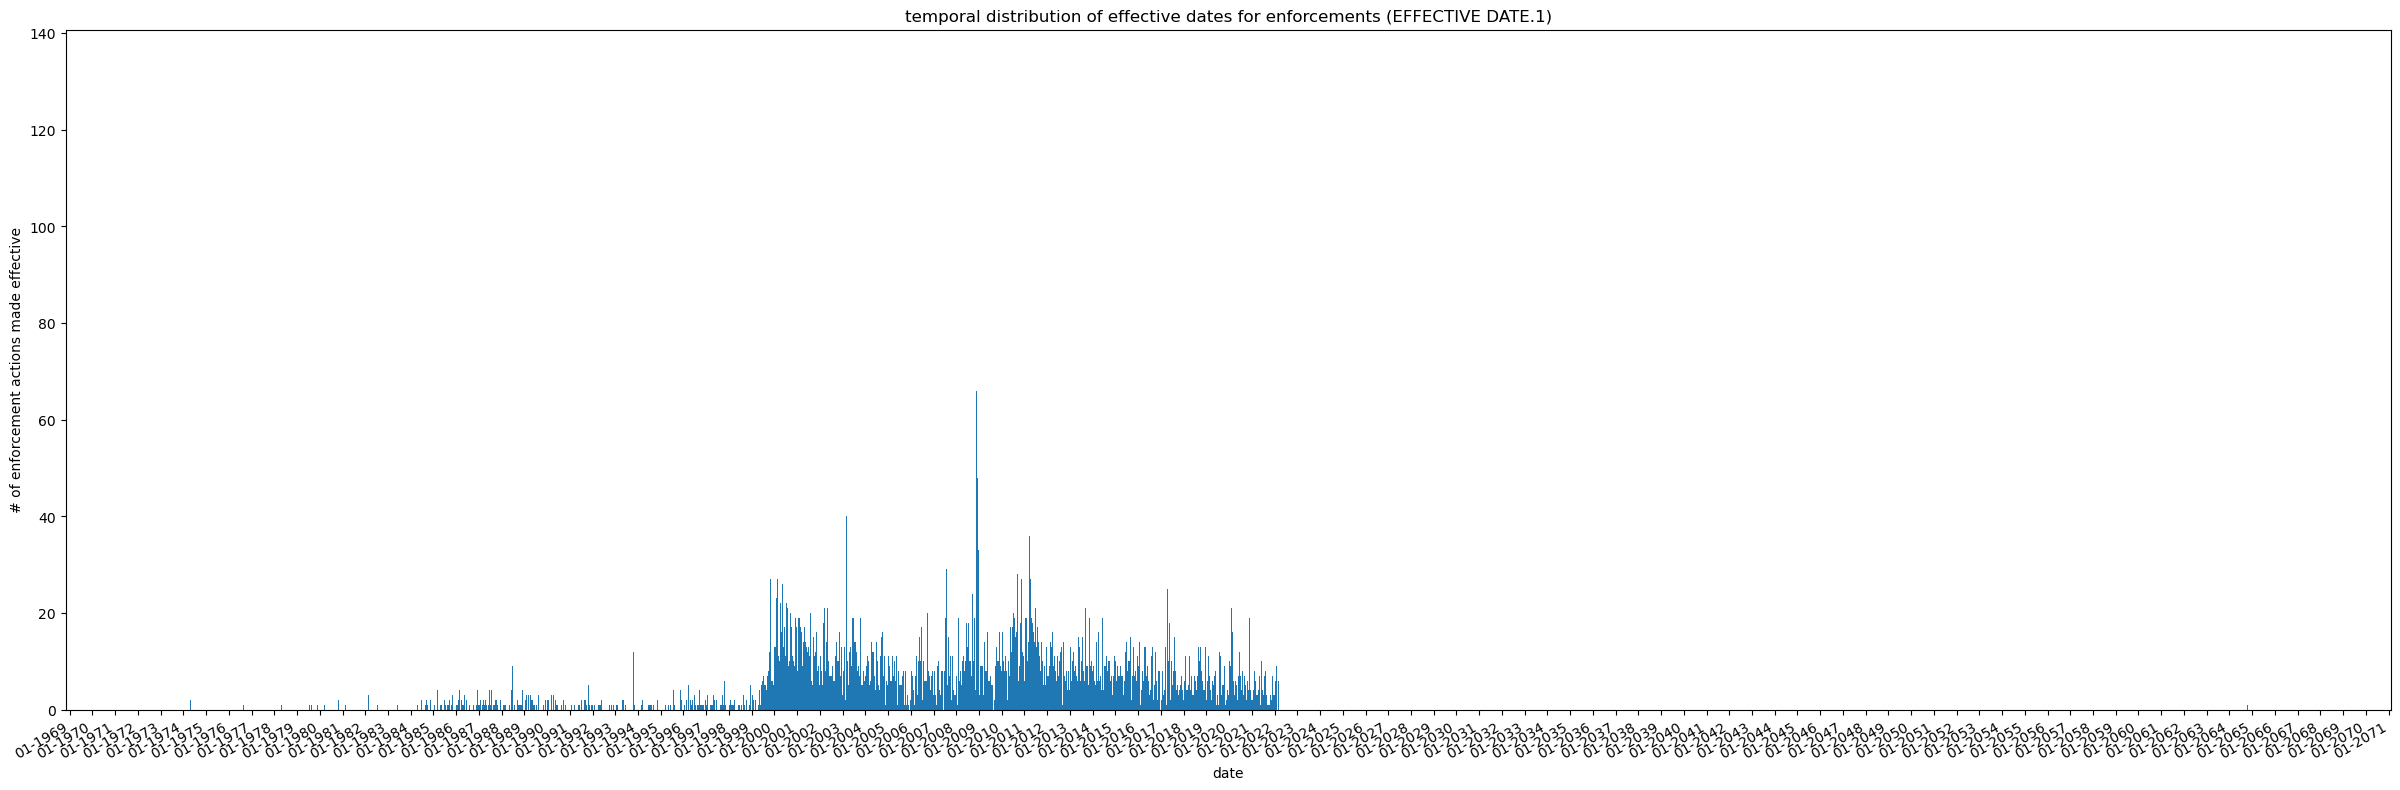

In [9]:
# count of enforcement actions made effective over time
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.hist(enforcements['EFFECTIVE DATE.1'], bins = len(pd.unique(enforcements['EFFECTIVE DATE.1'])))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()
ax.set_title('temporal distribution of effective dates for enforcements (EFFECTIVE DATE.1)')
ax.set_xlabel('date')
ax.set_ylabel('# of enforcement actions made effective')

In [10]:
# effective dates ('EFFECTIVE DATE.1') for enforcement actions that have an 'EPL ISSUANCE DATE'
print("effective dates (EFFECTIVE DATE.1) for enforcement actions w/EPL ISSUANCE DATE:\n", enforcements_EPL['EFFECTIVE DATE.1'].value_counts())

# range of effective dates (for enforcement actions WITH EPLs)
print("range of effective dates for enforcement actions w/EPL ISSUANCE DATE:\n", enforcements_EPL['EFFECTIVE DATE.1'].sort_values())

effective dates (EFFECTIVE DATE.1) for enforcement actions w/EPL ISSUANCE DATE:
 2008-12-02    38
2008-11-19    31
2008-12-19    26
2009-07-15    23
2010-08-03    21
              ..
2009-06-30     1
2011-08-12     1
2017-03-14     1
2020-03-18     1
2020-10-27     1
Name: EFFECTIVE DATE.1, Length: 655, dtype: int64
range of effective dates for enforcement actions w/EPL ISSUANCE DATE:
 31552   2008-07-01
26281   2008-07-01
32546   2008-07-01
11500   2008-07-24
36322   2008-07-24
           ...    
10799          NaT
25601          NaT
27927          NaT
27933          NaT
37882          NaT
Name: EFFECTIVE DATE.1, Length: 1299, dtype: datetime64[ns]


Text(0, 0.5, '# of enforcement actions with EPLs made effective')

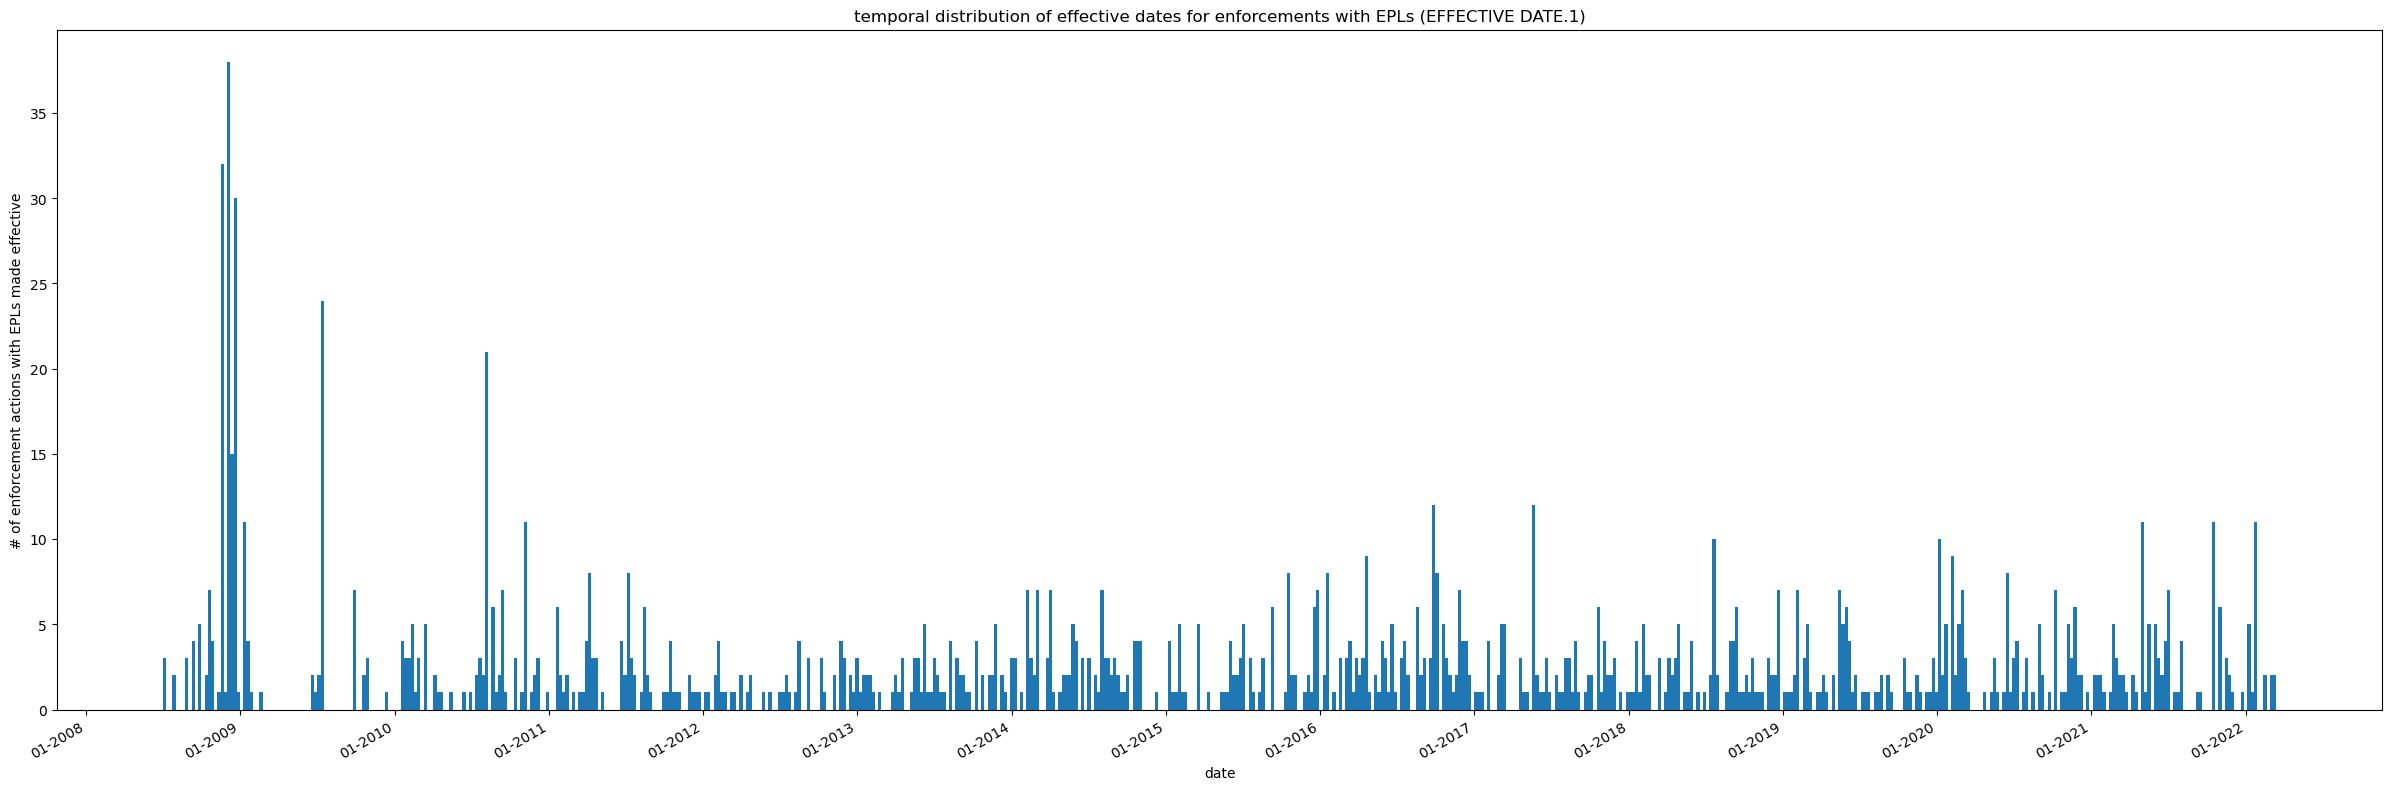

In [11]:
# effective dates for enforcement actions that do have an 'EPL ISSUANCE DATE' value
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.hist(enforcements_EPL['EFFECTIVE DATE.1'], bins = len(pd.unique(enforcements_EPL['EFFECTIVE DATE.1'])))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()
ax.set_title('temporal distribution of effective dates for enforcements with EPLs (EFFECTIVE DATE.1)')
ax.set_xlabel('date')
ax.set_ylabel('# of enforcement actions with EPLs made effective')

## Can we match the ground-truth EPLs to the enforcements file?

We have copies of ground-truth EPLs from Erin Mustain.

Goal: to see how these PDF copies of the original EPLs match up to the enforcement actions file.

In [12]:
# read in EPL ground truth (PDF files we have from Erin)
EPL_ground_truth = pd.read_excel(os.path.join(gdrive_dir, 'data', 'EPLs', 'EPL_ground_truth.xlsx'))
EPL_ground_truth['date'] = pd.to_datetime(EPL_ground_truth['date'], format='%m/%d/%Y', errors='coerce')

# how many copies of letters do we have for each EPL number?
#print(EPL_ground_truth['EPL_number'].value_counts())

# removing duplicates to create clean ground-truth dataframe
EPL_ground_truth_clean = EPL_ground_truth.drop_duplicates(subset=['date', 'EPL_number', 'NPDES_ID', 'WDID_number', 'permittee_name', 
                                                                  #'MMP_amount_effluent', 'MMP_amount_reporting', 'MMP_amount_total'  # ignoring MMP amounts for now (because what we care about is the date)
                                                                  ])

# checking for remaining duplicates based solely on EPL number
#EPL_ground_truth_duplicates_EPL_number = EPL_ground_truth_clean[EPL_ground_truth_clean.duplicated(subset=['EPL_number'], keep=False)]  # pulling out any remaining duplicates using only EPL number
#print('\nvalues of \'date\' in set of EPLs with non-unique EPL number:\n', (EPL_ground_truth_clean[EPL_ground_truth_clean.duplicated(subset=['EPL_number'], keep=False)])['date'].value_counts())

# keeping only one copy of each EPL (so no EPL numbers are repeated in the dataframe)
EPL_ground_truth_clean.sort_values(by='date')  # currently keeping the EPLs with earlier dates in case of EPLs that share an EPL number
EPL_ground_truth_clean.drop_duplicates(subset=['EPL_number'], inplace=True, keep='last')

print(f"number of unique EPLs in the ground-truth data: {len(EPL_ground_truth_clean['EPL_number'].unique())}")

# what's the distribution of dates in our cleaned set of ground-truth EPLs?
print('\nvalues of \'date\' (date on PDF letter) in set of unique ground-truth EPLs:\n', EPL_ground_truth_clean['date'].value_counts())

number of unique EPLs in the ground-truth data: 157

values of 'date' (date on PDF letter) in set of unique ground-truth EPLs:
 2008-12-09    95
2008-07-24    33
2008-07-01    20
2008-09-26     6
2009-01-29     2
2008-07-08     1
Name: date, dtype: int64


Summary:

- **We have 195 distinct letters from Erin.**

- There are 14 duplicate copies (7 pairs) of letters (from 9/26/08 and 12/9/08) in our files from Erin. This leaves us with 188 unique EPLs, where "unique" = unique combination of date, EPL number, NPDES ID, WDID number, permittee name, and MMP amounts (effluent, reporting, and total).

- What happens if we ignore MMP amounts?

    - We eliminate another 7 EPLs from our ground-truth data set, all of which come in pairs of EPLs with the same date, but different MMP amounts: SWB-2008-4-0015, SWB-2008-4-0019, SWB-2008-4-0047, SWB-2008-4-0057, SWB-2008-4-0080, SWB-2008-4-0087, and SWB-2008-4-0097.

    - (For now, assuming there's no reason to prioritize including/removing a letter with one MMP amount rather than another amount.)

- After removing the 7 letters from the duplicate pairs and 7 from the pairs with different MMP amounts, we have 181 EPLs remaining. There are still 48 letters (= 24 pairs) that share an EPL number. These are all cases where one EPL has a date of 12/9/08 and the other EPL (with the same EPL number) is dated 1/29/09.

- If we take only one copy from each pair of letters that share an EPL number (for now, taking the earlier date), we have **157 unique EPLs**.

Other notes:

- For all repeated EPL numbers in our ground-truth data, we have TWO letters with that EPL number. EXCEPTIONS: SWB-2008-4-0019 and SWB-2008-4-0047, for which we have THREE copies of letters with each order number.

In [13]:
# exploratory analysis of our ability to match ground truth to enforcement flat file
matched_EPLs = EPL_ground_truth_clean.merge(enforcements, left_on='EPL_number', right_on='ORDER / RESOLUTION NUMBER')
print('number of ground-truth EPLs matched to \'enf_actions_export.txt\':\n', len(matched_EPLs['EPL_number'].unique()), '(out of', len(EPL_ground_truth_clean), 'unique enforcement orders)')

# checking which EPLs don't get matched
all_EPLs = EPL_ground_truth_clean.merge(enforcements, how='outer', left_on='EPL_number', right_on='ORDER / RESOLUTION NUMBER', indicator=True)  # ALL EPLs (found either in ground truth or in enforcements file) 
unmatched_EPLs = all_EPLs.loc[all_EPLs['_merge']=='left_only']

number of ground-truth EPLs matched to 'enf_actions_export.txt':
 146 (out of 157 unique enforcement orders)


Here are the 8 EPLs we didn't match (when looking for an exact match between the order number on the EPL ('EPL_number') and the order number in 'enf_actions_export.txt'):

- All 6 of the EPLs dated 9/26/08 that we received from Erin. It looks like all of these just had parts of their order numbers switched around, but we do see these EPLs in the data.

    - SWB-4-2008-0001: seems to match order SWB-2008-4-0001.

    - SWB-4-2008-0002: SWB-2008-4-0002.

    - SWB-4-2008-0003: SWB-2008-4-0003.

    - SWB-4-2008-0004: SWB-2008-4-0004.

    - SWB-4-2008-0005: SWB-2008-4-0005.

    - SWB-4-2008-0006: SWB-2008-4-0006.

- SWB-2008-4-0060 - seems to correspond with SWB-2008-4-0060a.

    - "Mandatory Minimum Penalty Amount Owed for Effluent Violations (1 Serious Violation + 2 Chronic Violations) � $3,000 = $9,000 to the Cleanup & Abatement Account. Amended for $6000."

- SWB-2008-3-0020 - corresponds with WQO2018-0008-EXEC.

    - "Original EPL was issued on 7/1/2008 for $15,000 addressing 5 effluent Violations (2 Serious Violations + 3 Chronic Violations). Amended EPL issued on 12/7/2017 for $120,000 addressing 23 serious and 17 non-serious MMP violations."

**Key takeaway: we do actually find all of these enforcement orders in the data (i.e., there is at least SOME record of them).**

## Can we use the enforcements file to identify EPL issuance dates?

Goal: to find a heuristic that will allow us to figure out EPL issuance dates based on the enforcements file.

In [14]:
# checking if EPLs get matched 1:1 to enforcement data
print(f"EPLs matched to multiple rows of enforcement data:\n{matched_EPLs[matched_EPLs.duplicated(subset=['EPL_number'], keep=False)]['EPL_number']}\n")

# keep only enforcement actions with Active or Historical statuses (per 5/3/22 meeting w/Erin)
matched_EPLs_act_hist = matched_EPLs[(matched_EPLs['STATUS.1'] == 'Active') | (matched_EPLs['STATUS.1'] == 'Historical')]
print(f"number of EPLs matched to multiple rows after filtering for enforcements with only 'Active' or 'Historical' status: {len(matched_EPLs_act_hist[matched_EPLs_act_hist.duplicated(subset=['EPL_number'], keep=False)]['EPL_number'])}\n")

print(f"matched EPLs with 'Active' or 'Historical' status: {len(matched_EPLs_act_hist)}")

EPLs matched to multiple rows of enforcement data:
3     SWB-2008-4-0007
4     SWB-2008-4-0007
15    SWB-2008-4-0018
16    SWB-2008-4-0018
22    SWB-2008-4-0025
23    SWB-2008-4-0025
25    SWB-2008-4-0027
26    SWB-2008-4-0027
62    SWB-2008-4-0067
63    SWB-2008-4-0067
Name: EPL_number, dtype: object

number of EPLs matched to multiple rows after filtering for enforcements with only 'Active' or 'Historical' status: 0

matched EPLs with 'Active' or 'Historical' status: 92


Notes:

- There are five ground-truth EPLs that get matched to multiple rows in the enforcement data. All of these are non-issues after filtering for 'Active' or 'Historical' status, since in each pair of rows at least one is 'Withdrawn' or 'Draft' (and therefore gets filtered out).

date fields in enforcement data matched to set of ground-truth EPLs (total number of matched EPLs = 92):
           ACL ISSUANCE DATE    EPL ISSUANCE DATE
count                    49                   43
unique                    7                    5
top     2008-12-09 00:00:00  2008-12-09 00:00:00
freq                     22                   19
first   2008-07-01 00:00:00  2008-07-01 00:00:00
last    2009-10-30 00:00:00  2008-12-10 00:00:00

time differences (days) for 92 EPLs:
  0.0      80
 325.0     5
 1.0       3
-40.0      1
-93.0      1
Name: time_diff_days, dtype: int64

EPLs with no estimated date: 2


Text(0, 0.5, '# of enforcements')

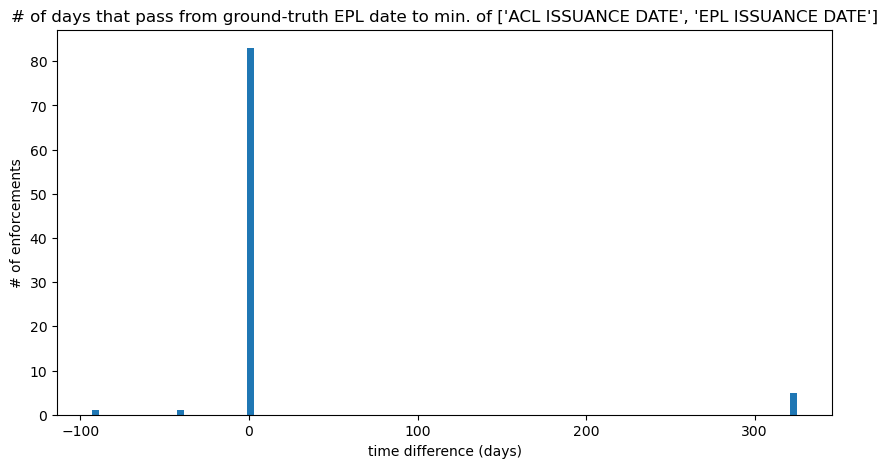

In [15]:
# looking at date fields
date_cols = [
    'ACL ISSUANCE DATE',
    'EPL ISSUANCE DATE'
    ]  # set of date columns that are being considered - can change this as desired (make sure they're read in at the beginning in datetime format)

print(f"date fields in enforcement data matched to set of ground-truth EPLs (total number of matched EPLs = {len(matched_EPLs_act_hist['EPL_number'].unique())}):\n", matched_EPLs_act_hist[date_cols].describe(include='all'))

# simple heuristic (#1): taking the earliest of the ACL & EPL issuance dates
matched_EPLs_act_hist['estimated_date'] = matched_EPLs_act_hist[date_cols].min(axis=1)
date_comparisons = matched_EPLs_act_hist[['EPL_number','date','estimated_date']].sort_values(['date', 'estimated_date'], ascending=[True, True])
date_comparisons['time_diff_days'] = (date_comparisons['estimated_date'] - date_comparisons['date']).dt.days
print(f"\ntime differences (days) for {len(matched_EPLs_act_hist['EPL_number'].unique())} EPLs:\n",date_comparisons['time_diff_days'].value_counts())

print(f"\nEPLs with no estimated date: {matched_EPLs_act_hist['estimated_date'].isnull().sum()}")

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.hist(date_comparisons['time_diff_days'], bins = 100)
ax.set_title('# of days that pass from ground-truth EPL date to min. of ' + str(date_cols))
ax.set_xlabel('time difference (days)')
ax.set_ylabel('# of enforcements')


date fields in enforcement data matched to set of ground-truth EPLs (total number of matched EPLs = 92):
           ACL ISSUANCE DATE    EPL ISSUANCE DATE
count                    51                   62
unique                    7                    8
top     2008-12-09 00:00:00  2008-12-09 00:00:00
freq                     23                   31
first   2008-07-01 00:00:00  2008-07-01 00:00:00
last    2009-10-30 00:00:00  2015-07-01 00:00:00

time differences (days) for 92 EPLs:
  0      81
 325     5
 1       3
 118     1
-40      1
-93      1
Name: time_diff_days, dtype: int64

EPLs with no estimated date: 0


Text(0, 0.5, '# of enforcements')

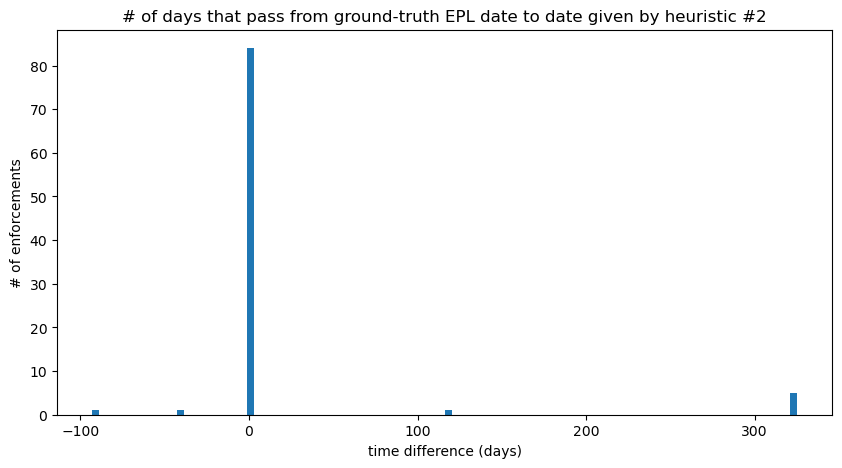

In [16]:
print(f"date fields in enforcement data matched to set of ground-truth EPLs (total number of matched EPLs = {len(matched_EPLs_act_hist['EPL_number'].unique())}):\n", matched_EPLs[date_cols].describe(include='all'))

# fancier heuristic (#2): take earliest of ACL and EPL issuance dates, and if NaN take 'EFFECTIVE DATE.1'
matched_EPLs_act_hist['estimated_date'] = matched_EPLs_act_hist[date_cols].min(axis=1)
matched_EPLs_act_hist['estimated_date'] = matched_EPLs_act_hist['estimated_date'].fillna(matched_EPLs['EFFECTIVE DATE.1'])
date_comparisons = matched_EPLs_act_hist[['EPL_number','date','estimated_date']].sort_values(['date', 'estimated_date'], ascending=[True, True])
date_comparisons['time_diff_days'] = (date_comparisons['estimated_date'] - date_comparisons['date']).dt.days
print(f"\ntime differences (days) for {len(matched_EPLs_act_hist['EPL_number'].unique())} EPLs:\n",date_comparisons['time_diff_days'].value_counts())

print(f"\nEPLs with no estimated date: {matched_EPLs_act_hist['estimated_date'].isnull().sum()}")

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.hist(date_comparisons['time_diff_days'], bins = 100)
ax.set_title('# of days that pass from ground-truth EPL date to date given by heuristic #2')
ax.set_xlabel('time difference (days)')
ax.set_ylabel('# of enforcements')

**Taking the minimum of the 'ACL ISSUANCE DATE' and the 'EPL ISSUANCE DATE' seems to be a reasonably good heuristic, but it's not foolproof.**

- For 84/94 EPLs, we're within 1 day of the true date.

- 2/94 (SWB-2008-2-0006 and SWB-2008-2-0015) don't have dates in either of those fields, so we can't identify a date for them.

- For cases for which the heuristic fails (8/94), our error ranges from -93 to +325 days. What's going on with these? 
    - For all of the EPLs with a +325 day difference, the ground-truth issuance date was 12/9/08 and the heuristic yields 10/30/09.
    - For the others, the heuristic yields either 10/28/08 or 10/30/08.
    - There's a bit of a pattern here, but the explanation isn't immediately clear. Is there some reason that these dates (10/28/08, 10/30/08, and 10/30/09) matter? Perhaps there's a commonality in what was going on institutionally at the time.

**The 'ADOPTION / ISSUANCE DATE' and 'EFFECTIVE DATE.1' fields do NOT correspond accurately to EPL dates.** Incorporating these fields into our heuristic introduces large errors.

If we want to account for cases where we have neither an 'EPL ISSUANCE DATE' value nor an 'ACL ISSUANCE DATE' value, we could consider using the 'EFFECTIVE DATE.1' field as a backup. We could also consider dropping those cases, although given our limited sample sizes this may be less ideal. It's a little hard to identify whether this is a viable addition to the heuristic given that it only catches 2 of our ground-truth cases.

## How do we accurately identify EPLs from the enforcement actions file?

Goal: to figure out the size of the EPL universe.

In [17]:
print(f"total number of enforcements in 'enf_actions_export.txt': {len(enforcements)}")

# filter enforcements by status
enforcements_of_interest = enforcements[(enforcements['STATUS.1'] == 'Active') | (enforcements['STATUS.1'] == 'Historical')]  
print(f"\nnumber of enforcements w/'Active' or 'Historical' status: {len(enforcements_of_interest)}")
# filter by enforcement action type
enforcements_of_interest = enforcements_of_interest[(enforcements_of_interest['ENFORCEMENT ACTION TYPE'] == 'Admin Civil Liability') | (enforcements_of_interest['ENFORCEMENT ACTION TYPE'] == 'Expedited Payment Letter')]
print(f"\nwhen additionally filtered to have ACL or EPL as 'ENFORCEMENT ACTION TYPE': {len(enforcements_of_interest)}")

# testing two different ways to ID NPDES permittees
print("\nidentifying NPDES permittees:")
# note: Erin says the 'NPDES # CA#' field isn't mandatory (see notes from 5 July 2022), so don't want to filter on that
enforcements_of_interest_NPDES_ID = enforcements_of_interest.dropna(subset=['NPDES # CA#'])  # use NPDES ID field
print(f"    have NPDES ID: {len(enforcements_of_interest_NPDES_ID)}")
NPDES_programs = ['DODNPDESSW','DODNPDESWW','NPDESWW','NPDINDLRG','NPDINDSML','NPDMINING','NPDMUNILRG','NPDMUNIOTH','NPDNONMUNIPRCS']
pattern = '|'.join(NPDES_programs)
enforcements_of_interest['NPDES_program_flag'] = enforcements_of_interest['PROGRAM'].str.contains(pattern).fillna(False)
enforcements_of_interest_NPDES_program = enforcements_of_interest[enforcements_of_interest.NPDES_program_flag]  # use NPDES programs
print(f"    under NPDES programs: {len(enforcements_of_interest_NPDES_program)}")

total number of enforcements in 'enf_actions_export.txt': 10813

number of enforcements w/'Active' or 'Historical' status: 10150

when additionally filtered to have ACL or EPL as 'ENFORCEMENT ACTION TYPE': 2531

identifying NPDES permittees:
    have NPDES ID: 2489
    under NPDES programs: 2531


In [18]:
# checking which EPLs don't get matched if we subset the enforcement file to only actions w/a NPDES ID
matched_EPLs_NPDES = EPL_ground_truth_clean.merge(enforcements_of_interest_NPDES_ID, left_on='EPL_number', right_on='ORDER / RESOLUTION NUMBER', indicator=True)
print('\nnumber of ground-truth EPLs matched to \'enf_actions_export.txt\' when subsetted to enforcement actions w/NPDES ID:\n', len(matched_EPLs_NPDES['EPL_number'].unique()), '(out of', len(EPL_ground_truth_clean['EPL_number'].unique()), 'unique enforcement orders)')

# checking which EPLs don't get matched if we subset the enforcement file to only actions under a NPDES program
matched_EPLs_NPDES = EPL_ground_truth_clean.merge(enforcements_of_interest_NPDES_program, left_on='EPL_number', right_on='ORDER / RESOLUTION NUMBER', indicator=True)
print('\nnumber of ground-truth EPLs matched to \'enf_actions_export.txt\' when subsetted to enforcement actions in NPDES program:\n', len(matched_EPLs_NPDES['EPL_number'].unique()), '(out of', len(EPL_ground_truth_clean['EPL_number'].unique()), 'unique enforcement orders)')


#all_EPLs_NPDES = EPL_ground_truth_clean.merge(enforcements_NPDES, how='outer', left_on='EPL_number', right_on='ORDER / RESOLUTION NUMBER', indicator=True)
#unmatched_EPLs_NPDES = all_EPLs_NPDES.loc[all_EPLs_NPDES['_merge']=='left_only']


number of ground-truth EPLs matched to 'enf_actions_export.txt' when subsetted to enforcement actions w/NPDES ID:
 91 (out of 157 unique enforcement orders)

number of ground-truth EPLs matched to 'enf_actions_export.txt' when subsetted to enforcement actions in NPDES program:
 92 (out of 157 unique enforcement orders)
